## A Draft of a FineTuning Tutorial

All credit for model and implementation go to Divam & Francois: I simply added the `add_tokens()` method to the `SimpleTokenizer`.  To run this notebook, you need to have my fork installed so that you can use the `add_tokens()` method.

**Instructions**: Install the branch of KerasCV hosted here: https://github.com/LukeWood/keras-cv/tree/lukewoodstablediffusion2

Now on to the tutorial draft...

# Textual Inversion

StableDiffusion: the first high quality open soruce image generator.  Since its
release, StableDiffusion has quickly become a favorite amongst the machine learning
community.  The high volume of traffic has led to open source contributed improvements,
heavy prompt engineering, and even the invention of novel algorithms.

Perhaps the most impressive new algorithm being used is
[Textual-inversion](https://github.com/rinongal/textual_inversion), presented in
[_An Image is Worth One Word: Personalizing Text-to-Image Generation using Textual Inversion_](https://textual-inversion.github.io/)

Textual-inversion is the process of teaching an Image-Generator the concept of a specific
thing through the use of FineTuning. In the diagam below, you can see an example of
this process where the authors teach the model new concepts, calling them "S_*".

![https://i.imgur.com/KqEeBsM.jpg](https://i.imgur.com/KqEeBsM.jpg)

This guide shows you how to fine-tune the StableDiffusion model shipped in KerasCV
using the Textual-Inversion algorithm.

First, lets start by important the packages we will need, and constructing StableDiffusion so we can use some of the sub-components for fine-tuning.

In [1]:
import keras_cv
from keras_cv import layers as cv_layers
import tensorflow as tf
from tensorflow import keras
from luketils import visualization
import numpy as np

stable_diffusion = keras_cv.models.StableDiffusion()

## Generating a Fine-Tuning dataset

First, we need to generate a Fine-Tuning dataset.
This dataset must consist of text to image pairs, just as you would expect with a
text-to-image model.

First, lets fetch our images.  By default, the StableDiffusion model in KerasCV uses
an image size of 512x512.  As such, we resize our images to 512x512.


In [2]:
urls = [
    "https://i.imgur.com/VIedH1X.jpg",
    "https://i.imgur.com/1WCfWUt.jpg",
    "https://i.imgur.com/eBw13hE.png",
]
files = [tf.keras.utils.get_file(origin=url) for url in urls]

# Resize images
resize = keras.layers.Resizing(height=512, width=512, crop_to_aspect_ratio=True)
images = [keras.utils.load_img(img) for img in files]
images = [keras.utils.img_to_array(img) for img in images]
images = np.array([resize(img) for img in images])

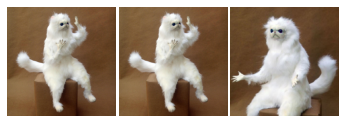

In [3]:
visualization.plot_gallery(images, value_range=(0, 255), rows=1, columns=3, show=True)

StableDiffusion expects images to be in the value range (-1, 1), so lets normalize to that range:

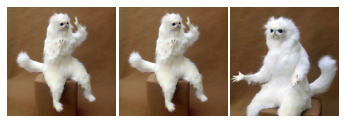

In [4]:
images = (images/127.5 - 1)
visualization.plot_gallery(images, value_range=(-1, 1), rows=1, columns=3, show=True)

Looks good!

Next, we'll need to produce accompanying text prompts.
Here is a small set of prompts we can use to generate a simple dataset.
If you're finetuning on a style you should use the style prompts separate set of prompts.

In [5]:
object_prompts = [
    "a photo of a {}",
    "a rendering of a {}",
    "a cropped photo of the {}",
    "the photo of a {}",
    "a photo of a clean {}",
    "a photo of a dirty {}",
    "a dark photo of the {}",
    "a photo of my {}",
    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a bright photo of the {}",
    "a cropped photo of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a photo of one {}",
    "a close-up photo of the {}",
    "a rendition of the {}",
    "a photo of the clean {}",
    "a rendition of a {}",
    "a photo of a nice {}",
    "a good photo of a {}",
    "a photo of the nice {}",
    "a photo of the small {}",
    "a photo of the weird {}",
    "a photo of the large {}",
    "a photo of a cool {}",
    "a photo of a small {}",
]

style_prompts = [
    "a painting in the style of {}",
    "a rendering in the style of {}",
    "a cropped painting in the style of {}",
    "the painting in the style of {}",
    "a clean painting in the style of {}",
    "a dirty painting in the style of {}",
    "a dark painting in the style of {}",
    "a picture in the style of {}",
    "a cool painting in the style of {}",
    "a close-up painting in the style of {}",
    "a bright painting in the style of {}",
    "a cropped painting in the style of {}",
    "a good painting in the style of {}",
    "a close-up painting in the style of {}",
    "a rendition in the style of {}",
    "a nice painting in the style of {}",
    "a small painting in the style of {}",
    "a weird painting in the style of {}",
    "a large painting in the style of {}",
]

Next, lets pick a token for our new concept.
In this guide, we use the token `"<S*>"`, but the concept
can be named anything

In [6]:
placeholder_token = "<my-funny-cat-token>"

In [7]:
object_prompts = [prompt.format(placeholder_token) for prompt in object_prompts]
style_prompts = [prompt.format(placeholder_token) for prompt in style_prompts]
print('object prompt:', object_prompts[0])
print('style prompt:', style_prompts[0])

object prompt: a photo of a <my-funny-cat-token>
style prompt: a painting in the style of <my-funny-cat-token>


Now all that is left to do is a package the datsaet into a `tf.data` pipeline.

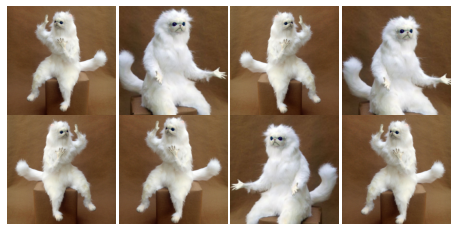

In [8]:
image_dataset = tf.data.Dataset.from_tensor_slices(images)
image_dataset = image_dataset.shuffle(100)
image_dataset = image_dataset.map(cv_layers.RandomCropAndResize(target_size=(512, 512), crop_area_factor=(0.8, 1.0), aspect_ratio_factor=(1.0, 1.0)), num_parallel_calls=tf.data.AUTOTUNE)
image_dataset = image_dataset.map(cv_layers.RandomFlip(mode='horizontal'), num_parallel_calls=tf.data.AUTOTUNE)
image_dataset = image_dataset.repeat()

item = next(iter(image_dataset.batch(8).take(1)))
visualization.plot_gallery(item, value_range=(-1, 1), rows=2, columns=4, show=True)

Great!  Our images are correctly augmented in a performant `tf.data.Dataset` pipeline.

For text, we first pass our embeddings through the `stable_diffusion.tokenizer.encode()` method.

In [9]:
# Replace with style_prompts if you'd like to finetune on a style
embeddings = [
    stable_diffusion.tokenizer.encode(prompt) for prompt in object_prompts
]
print(f'{object_prompts[0]} => {embeddings[0]}')

a photo of a <my-funny-cat-token> => [49406, 320, 1125, 539, 320, 283, 607, 268, 3789, 268, 2368, 268, 17134, 285, 49407]


A naive pass through is not sufficient though!
For high quality finetuning, we must add a special token to the tokenizer:

In [10]:
stable_diffusion.tokenizer.add_tokens(placeholder_token)
# Replace with style_prompts if you'd like to finetune on a style
embeddings = [
    stable_diffusion.tokenizer.encode(prompt) for prompt in object_prompts
]
print(f'{object_prompts[0]} => {embeddings[0]}')

a photo of a <my-funny-cat-token> => [49406, 320, 1125, 539, 320, 48973, 49407]


In [11]:
MAX_PROMPT_LENGTH = 77
def pad_embedding(embedding):
    return embedding + ([49407] * (MAX_PROMPT_LENGTH - len(embedding)))

embeddings = [
    np.array(pad_embedding(embedding)) for embedding in embeddings
]
text_dataset = tf.data.Dataset.from_tensor_slices(embeddings)

Great!    As you can see, `320, 283, 607, 268, 3789, 268, 2368, 268, 17134, 285` became
a single token: `48973`.  This is the special token we have constructed for `<my-funny-cat-token>`.

In [12]:
train_ds = tf.data.Dataset.zip((image_dataset, text_dataset))
train_ds = train_ds.batch(1)

## Training

Now we can move on to the exciting part: training!

In TextualInversion the only piece of the model that is trained is the embedding vector.  Lets freeze the rest of the model.

In [13]:
stable_diffusion.diffusion_model.trainable = False
stable_diffusion.decoder.trainable = False
stable_diffusion.text_encoder.trainable = True

In [14]:
stable_diffusion.text_encoder.layers[2].trainable = True

In [15]:
def traverse_layers(layer):
    if hasattr(layer, 'layers'):
        for layer in layer.layers:
            yield layer
    if hasattr(layer, 'token_embedding'):
        yield layer.token_embedding
    if hasattr(layer, 'position_embedding'):
        yield layer.position_embedding

for layer in traverse_layers(stable_diffusion.text_encoder):
    if isinstance(layer, keras.layers.Embedding) or 'clip_embedding' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

In [16]:
all_models = [
    stable_diffusion.text_encoder,
    stable_diffusion.diffusion_model,
    stable_diffusion.decoder
]
print([[w.shape for w in model.trainable_weights] for model in all_models])

[[TensorShape([49408, 768]), TensorShape([77, 768])], [], []]


Great!  Our weights are correctly frozen; except for the ClipEmbedding layer.

Next, we must produce a `DDPMNoiseScheduler`.  Our `DDPMNoiseScheduler` is based on the [HuggingFace implementation](https://github.com/huggingface/diffusers/blob/v0.3.0/src/diffusers/schedulers/scheduling_ddpm.py#L56).

In [17]:
# TODO(lukewood): add noise to the latents

Finally, we implement a `StableDiffusionFineTuner`.  The `StableDiffusionFineTuner` is a subclass of `keras.Model` with a custom `train_step()` override.

In [ ]:
class StableDiffusionFineTuner(keras.Model):
    def __init__(self, stable_diffusion, **kwargs):
        super().__init__(**kwargs)
        self.stable_diffusion = stable_diffusion

    def train_step(self, data):
        images, embeddings = data
        # to train the model, we actually need the VAE Encoder - which is not currently
        # available in the package.
        # Here is the best implementation of the VAE Encoder:
        # https://github.com/huggingface/diffusers/blob/d934d3d79519653ad4db5b63a7665c1536b4187c/src/diffusers/models/vae.py#L485
        
        # Encoder:
        # https://github.com/huggingface/diffusers/blob/d934d3d79519653ad4db5b63a7665c1536b4187c/src/diffusers/models/vae.py#L54
        return {'loss': 0.}

To monitor training, we can produce a `keras.callbacks.Callback` to produce an image every epoch using our custom token.

In [19]:
class GenerateImageEachEpoch(keras.callbacks.Callback):
    def __init__(self, stable_diffusion, prompt, **kwargs):
        super().__init__(**kwargs)
        self.stable_diffusion = stable_diffusion
        self.prompt = prompt

    def on_epoch_end(self, epoch, logs):
        images = self.stable_diffusion.text_to_image(self.prompt, batch_size=3)
        visualization.plot_gallery(images, value_range=(0, 255), rows=1, columns=3, show=True)

Next we can just `compile()` and `fit()` our model like any other Keras model!

In [20]:
trainer = StableDiffusionFineTuner(stable_diffusion, name="trainer")

Epoch 1/10
1/3 [=========>....................] - ETA: 0s - loss: 0.0000e+00

  0   1: 100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [01:13<00:00,  2.96s/it]


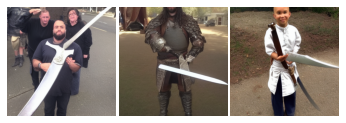

3/3 [==============================] - 94s 47s/step - loss: 0.0000e+00
Epoch 2/10
1/3 [=========>....................] - ETA: 0s - loss: 0.0000e+00

  0   1: 100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [01:01<00:00,  2.44s/it]


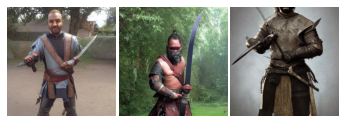

3/3 [==============================] - 63s 32s/step - loss: 0.0000e+00
Epoch 3/10
1/3 [=========>....................] - ETA: 0s - loss: 0.0000e+00

  0   1: 100%|████████████████████████████████████████████████████████████████████████████████| 25/25 [01:01<00:00,  2.44s/it]


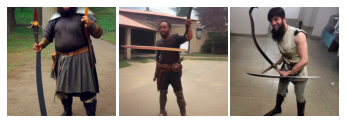

3/3 [==============================] - 64s 32s/step - loss: 0.0000e+00
Epoch 4/10
1/3 [=========>....................] - ETA: 0s - loss: 0.0000e+00

 23 921:   4%|███▏                                                                             | 1/25 [00:03<01:27,  3.64s/it]


KeyboardInterrupt: 

In [21]:
optimizer = keras.optimizers.SGD(learning_rate=5e-4)
trainer.compile(optimizer=optimizer, loss='mse')
trainer.fit(
    train_ds, 
    epochs=10,
    steps_per_epoch=3, 
    callbacks=[
        GenerateImageEachEpoch(stable_diffusion, prompt='<my-funny-cat-token> holding a sword')
    ]
)